# Introduccion

Considere el siguiente sistema
![](practico4.png)
donde $g[n]=g(nT_s)$ y 
$$g(t) = sinc (t/T) \frac{cos (\pi\beta t/T)}{
1 − 4\beta^2 t^2/T^2} $$ 
- Muestre que 

$$y_r(t)=\sum_n y[n]h_r(t − nTs) ->  Y_r(j\omega) = H_r (j\omega)Y(e^{j\omega T_s} )$$

- Teniendo en cuenta que $Y(e^{j\omega T_s} ) = X(e^{j\omega T_s} )G(e^{j\omega T_s} )$, se tiene que

$$ Y_r (j\omega) = H_r (j\omega)Y(e^{j\omega T_s }) $$ $$ Y_r (j\omega) = H_r (j\omega)G(e^{j\omega T_s})X(e^{j\omega T_s}) $$
$$ Y_r (j\omega) = H_t(j\omega)X(e^{j\omega T_s}) $$

- Grafique y analice el espectro a la salida del transmisor (i.e.,
$|Ht(j\omega)|^2)$ para diferentes condiciones de funcionamiento:
  - Distintos valores de sobremuestreo M = T/Ts (e.g., M =2, 4).
  - Distintos filtros reconstructores:
    * Filtro 0: $h_r (t) = sinc (t/T_s) \frac{cos (\pi\beta t/T_s)}{
1 − 4\beta^2 t^2/T_s^2}$
    * Filtro 1: $h_r (t) = rect(t,T_s)$ (pulso rectangular de ancho $T_s$)
    * Filtro 2: $h_r (t) = rect(t,T_s) \ast f_{\omega_c , P}(t)$ ( filtro pasabajo Butterworth de orden P)



# Desarrollo

## Funciones generadoras de sistemas

Se escriben funciones que toman tasa de sobremuestreo y tipo de filtro reconstructor como parametro

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as pl
from pylab import rcParams
rcParams['figure.figsize'] =  12,8
import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['text.latex.unicode'] = False
import scipy.signal

In [3]:
def generate_system(M_f=4,h_type=0):
    fB = 32e9;	# Velocidad de simbolos (baud rate)
    T = 1/fB; # Tiempo entre simbolos
    M = M_f;  #Factor de sobremuestreo
    fs = fB*M;	# Sample rate
    Ts=1./fs
    Tc=Ts/(64/M)
    beta = .123#; %Factor de roll-off
    beta_h=0.1
    L = 20;  # 2*L*M+1 es el largo del filtro sobremuestreado
    L_r = 1024*14 #Largo del filtro reconstructor
    t = np.arange(-L,L,1./M)*T#[-L:1/M:L]*T;
    t_r=np.arange(-L_r*Tc,L_r*Tc,Tc)
    n_delay_filter = L*M# %Retardo del filtro
    def gen_filter():
        return [np.sinc(t2/T)*np.cos(np.pi*beta*t2/T)
                /(1-4*beta**2*t2**2/T**2) for t2 in t];
    def gen_h_filter():
        return [np.sinc(t2/Ts)*(np.cos(np.pi*beta_h*t2/Ts)
                                /(1-4*beta_h**2*t2**2/Ts**2)) 
                                for t2 in t_r];
    def gen_pulse():
        return [1]*(int(Ts/Tc))
    def gen_pulse_and_butter():
        b,a=scipy.signal.butter(3,0.1)
        imp=scipy.signal.lfilter(a=a,b=b,x=[1./int(Ts/Tc)]*(int(Ts/Tc))+[0]*16)
        return np.convolve(imp,gen_pulse())
    
    ht_type=[gen_h_filter(),gen_pulse(),gen_pulse_and_butter()]
    gn=gen_filter()
    ht=ht_type[h_type]
    return gn,ht,Tc,Ts,t,t_r



## Impulsos de ejemplo

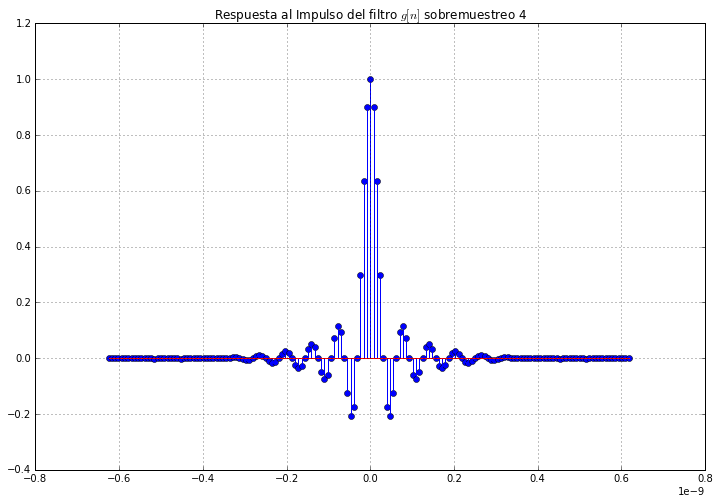

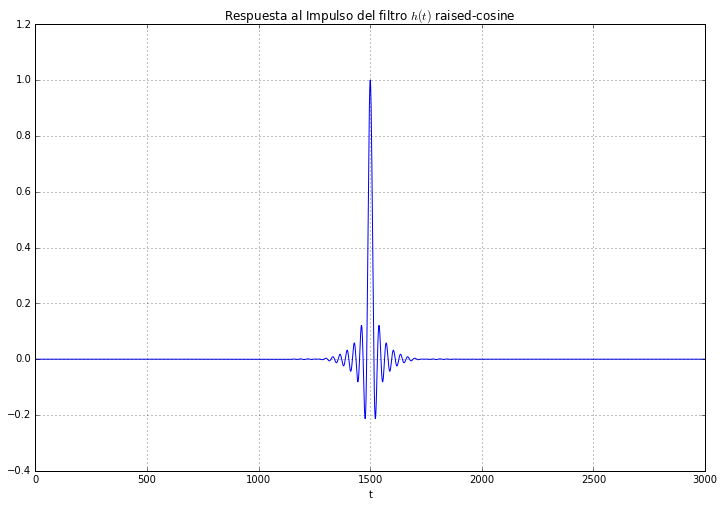

In [4]:
#pl.figure(figsize=(14,10))
gn,ht,Tc,Ts,t,t_r=generate_system(h_type=0)
pl.title('Respuesta al Impulso del filtro $g[n]$ sobremuestreo 4');
pl.stem(t,gn)
pl.grid(True)


pl.figure()
pl.plot(ht[-len(ht)/2-1500:len(ht)/2+1500])
pl.title('Respuesta al Impulso del filtro $h(t)$ raised-cosine');
pl.xlabel('t');
pl.grid(True)
pl.draw()


## Generacion de Graficas 

Se barren los tres tipos de filtros reconstructores para sobremuestreos = ${2,4,8,16}$.
Se muestran los impulsos resultantes y su grafica $|Ht(j\omega)|^2)$

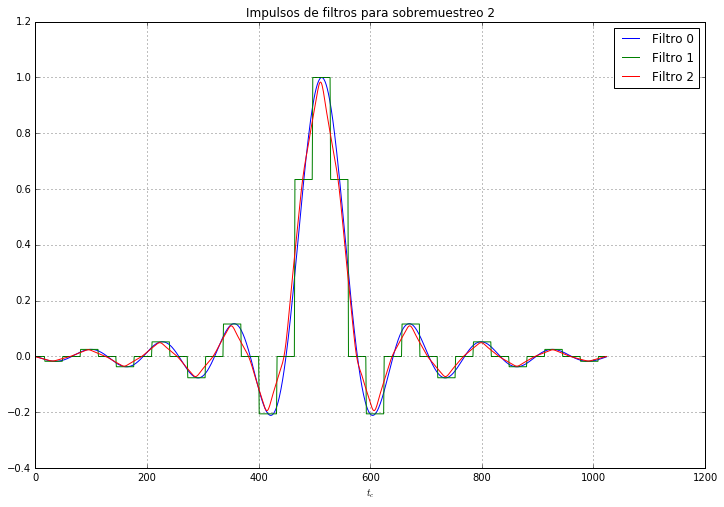

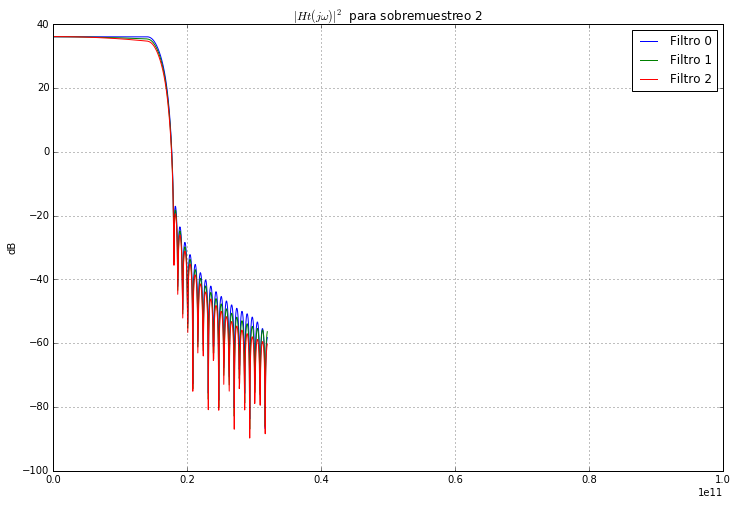

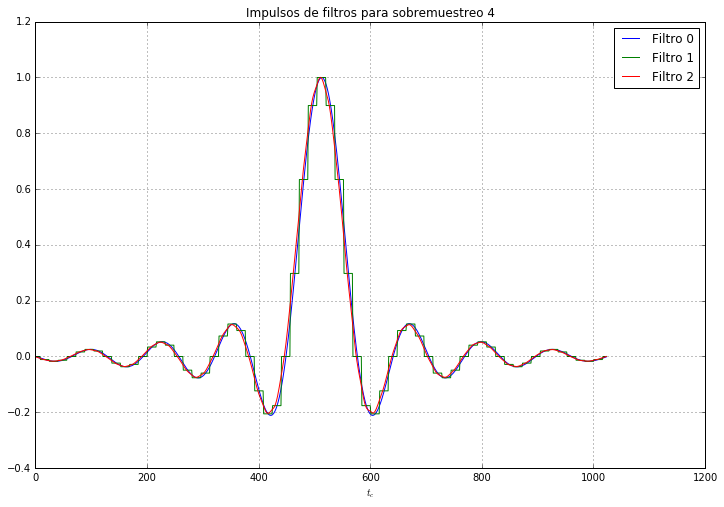

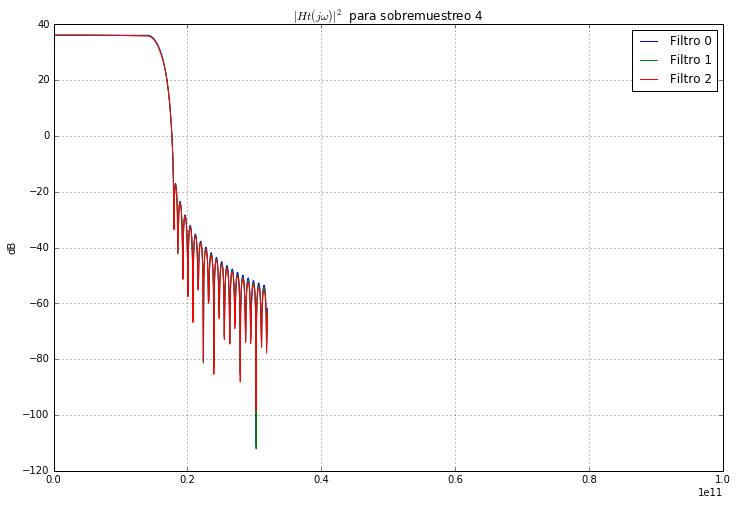

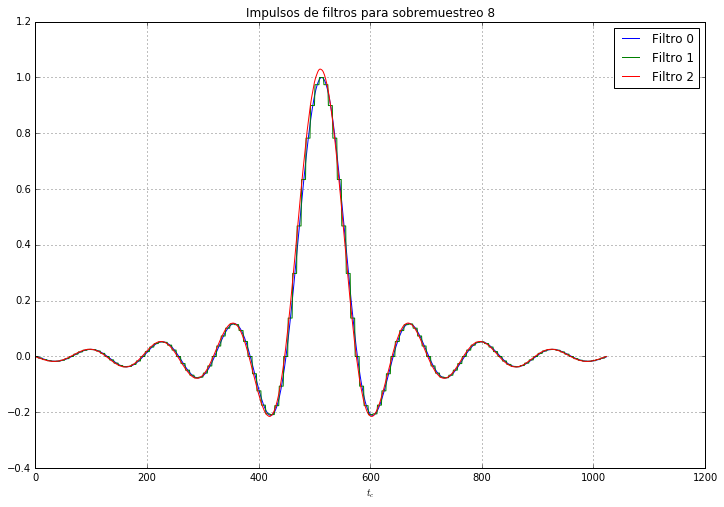

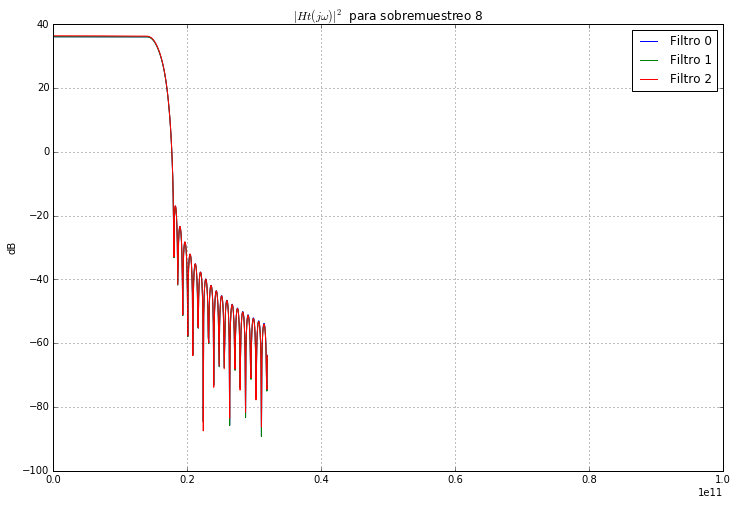

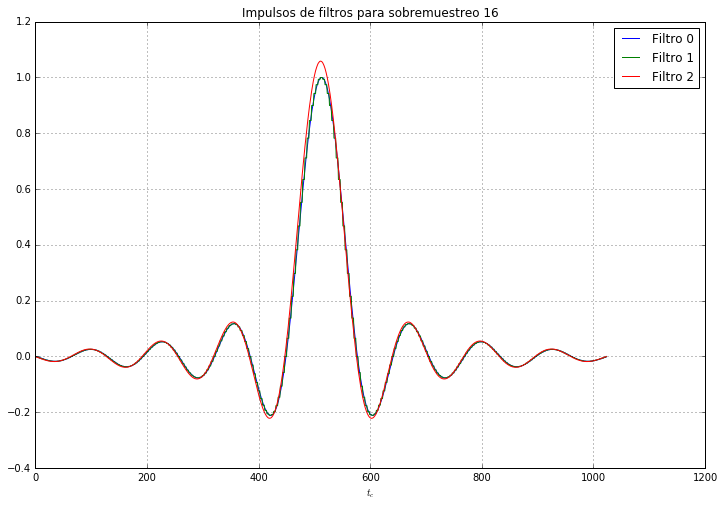

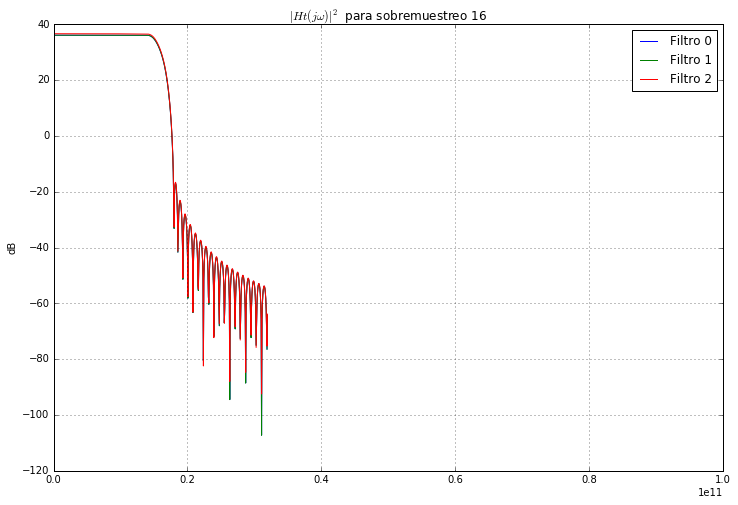

In [5]:

for k in range(3):
    for i in [2,4,8,16]:
        gn,ht,Tc,Ts,t,t_r=generate_system(M_f=i,h_type=k)
        gt=[]
        for j in xrange(len(gn)):
            gt.append(gn[j])
            gt.extend(list(np.zeros(64/i-1)))

        pl.figure(i+1)
        htt=np.convolve(ht,gt,mode='same')
        
        pl.plot(htt[len(htt)/2-512:len(htt)/2+512],label='Filtro '+str(k))
        pl.grid(True)
        pl.title('Impulsos de filtros para sobremuestreo '+str(i))
        pl.legend()
        pl.xlabel(r'$t_c$')
        pl.draw()
        
        pl.figure(i+2)
        from scipy import signal
        w,Htw=signal.freqz(htt,worN=2048*8)
        #Htw,w=pl.psd(htt,Fs=1/Tc,scale_by_freq=False)
        pl.xlim([0,1e11])
        #pl.figure(3)
        pl.plot(1/(Tc*2*np.pi)*w[:512],20*np.log10(abs(Htw[:512])),label='Filtro '+str(k))
        pl.title(r'$|Ht(j\omega)|^2$  para sobremuestreo '+str(i))
        pl.ylabel('dB')
        #pl.psd(htt,Fs=1/Tc)
        pl.hold(True)
        pl.grid(True)
        pl.legend()
        pl.draw()